In [2]:
pip install causalinference

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from causalinference import CausalModel
from matplotlib import pyplot as plt

In [4]:
pd.set_option('display.max_columns', None)

In [6]:
ci_temp = pd.read_csv('disparity_data.csv')
ci_temp.head()

,employee_id,gender_binary,Cad Count,Complaints Count Sus,Complaints Count,Highest Rank,Io Report Count,Dollars Earned (Gross),Certifications Count,Unit Count,Military Experience,Hours Worked,Max. Comp. Rate,Promotion Count,American Indian/Alaska Native,Asian,Black or African American,Hispanic or Latino,Nat Hawaiian/Oth Pac Islander,Two or More Races,Unknown,White,Last Pay Year,Year of Birth
0,17240,0,368,0,0,10,0,1347287.04,0,2,0,21974.70,115.88,1,0,1,0,0,0,0,0,0,2021,1954
1,15141,0,578,2,2,11,2,1199434.84,0,2,0,18529.00,117.38,1,0,0,0,0,0,0,0,1,2021,1958
2,17500,1,256,10,13,6,4,1575919.38,3,4,0,26913.95,95.70,0,0,0,1,0,0,0,0,0,2024,1955
3,14401,1,696,8,8,4,25,813363.21,0,1,0,14243.00,98.58,0,0,0,0,0,0,0,0,1,2017,1955
4,15276,1,31,0,0,6,0,814710.78,0,1,0,15050.75,100.76,0,0,0,0,0,0,0,0,1,2019,1956


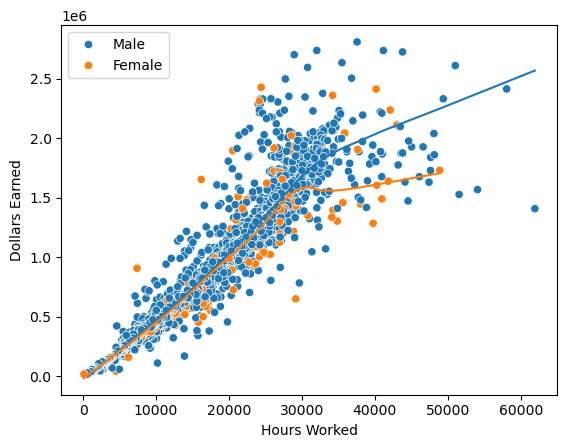

In [7]:
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

ax = sns.scatterplot(data=ci_temp, x='Hours Worked', y='Dollars Earned (Gross)', hue='gender_binary')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Male', 'Female'])
plt.ylabel('Dollars Earned')
# Calculate LOWESS for each gender
for gender in ci_temp['gender_binary'].unique():
    subset = ci_temp[ci_temp['gender_binary'] == gender]
    lowess = sm.nonparametric.lowess(subset['Dollars Earned (Gross)'], subset['Hours Worked'], frac=0.4) #40% of data per local regression

    ax.plot(lowess[:, 0], lowess[:, 1])
plt.show()

### Complaints

In [8]:
#Raw difference (differences in unbalanced average)

causal = CausalModel(Y = ci_temp['Complaints Count'].values,
                     D = ci_temp['gender_binary'].values,                     
                     X = ci_temp[['Cad Count',
                                  'Dollars Earned (Gross)',
 'Io Report Count', 'Highest Rank', 'Certifications Count', 'Unit Count',
 'Military Experience', 'Hours Worked','Max. Comp. Rate',
 'Promotion Count',
 'American Indian/Alaska Native',
 'Asian',
 'Black or African American',
 'Hispanic or Latino',
 'Nat Hawaiian/Oth Pac Islander',
 'Two or More Races',
 'Unknown',
 'White',
 'Last Pay Year',
 'Year of Birth']].values)

print(causal.summary_stats)


Summary Statistics

                      Controls (N_c=1708)         Treated (N_t=307)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        6.228        7.086        4.762        6.798       -1.466

                      Controls (N_c=1708)         Treated (N_t=307)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0     5711.241     5197.321     4508.176     3949.580       -0.261
             X1   984647.022   583608.380   893654.121   541859.766       -0.162
             X2      653.060      774.331      642.134      744.662       -0.014
             X3        5.763        3.006        5.831        3.025        0.022
             X4        1.852        2.125        1.619        1.910       -0.116
      

In [9]:
causal.est_propensity()
print(causal.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept   -109.022        nan        nan        nan        nan        nan
            X0     -0.000      0.000     -5.859      0.000     -0.000     -0.000
            X1     -0.000      0.000     -3.773      0.000     -0.000     -0.000
            X2      0.001      0.000      4.523      0.000      0.000      0.001
            X3      0.046      0.038      1.191      0.234     -0.029      0.121
            X4     -0.019      0.045     -0.426      0.670     -0.108      0.069
            X5      0.242      0.044      5.529      0.000      0.156      0.328
            X6     -0.962      0.224     -4.295      0.000     -1.401     -0.523
            X7      0.000      0.000      2.927      0.003      0.000      0.000
            X8      0.002      0.007      0.241      0.809     -0.

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/causalinference/core/propensity.py:173: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(np.linalg.inv(H)))


In [10]:
causal.est_via_weighting()
print(causal.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.530      0.575     -0.923      0.356     -1.657      0.596



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


In [11]:
#propensity scores:
weights = causal.propensity['fitted']

In [12]:
#add weights to df
ci_temp['weights'] = weights 

In [13]:
causal.trim_s()
causal.cutoff

0.06430489882918944

In [14]:
print(causal.summary_stats)


Summary Statistics

                      Controls (N_c=1403)         Treated (N_t=294)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        5.355        6.373        4.793        6.879       -0.562

                      Controls (N_c=1403)         Treated (N_t=294)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0     4665.070     4247.372     4400.194     3806.886       -0.066
             X1   905313.330   557788.198   872232.144   521555.788       -0.061
             X2      577.390      752.568      637.592      750.357        0.080
             X3        5.763        2.954        5.735        2.828       -0.010
             X4        1.634        2.057        1.595        1.899       -0.020
      

In [15]:
causal.est_via_weighting()
print(causal.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.213      0.525     -0.405      0.685     -1.241      0.816



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


### Dollars

In [16]:
causal_d = CausalModel(Y = ci_temp['Dollars Earned (Gross)'].values,
                     D = ci_temp['gender_binary'].values,                     
                     X = ci_temp[['Cad Count',
                                  'Complaints Count Sus',
 'Io Report Count', 'Highest Rank', 'Certifications Count', 'Unit Count',
 'Military Experience', 'Hours Worked','Max. Comp. Rate',
 'Promotion Count',
 'American Indian/Alaska Native',
 'Asian',
 'Black or African American',
 'Hispanic or Latino',
 'Nat Hawaiian/Oth Pac Islander',
 'Two or More Races',
 'Unknown',
 'White',
 'Last Pay Year',
 'Year of Birth']].values)

print(causal_d.summary_stats)


Summary Statistics

                      Controls (N_c=1708)         Treated (N_t=307)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y   984647.022   583608.380   893654.121   541859.766   -90992.901

                      Controls (N_c=1708)         Treated (N_t=307)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0     5711.241     5197.321     4508.176     3949.580       -0.261
             X1        3.192        3.740        2.736        5.582       -0.096
             X2      653.060      774.331      642.134      744.662       -0.014
             X3        5.763        3.006        5.831        3.025        0.022
             X4        1.852        2.125        1.619        1.910       -0.116
      

In [17]:
causal_d.est_propensity()
print(causal_d.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept    -16.973        nan        nan        nan        nan        nan
            X0     -0.000      0.000     -6.089      0.000     -0.000     -0.000
            X1      0.003      0.019      0.144      0.886     -0.035      0.041
            X2      0.001      0.000      4.840      0.000      0.000      0.001
            X3     -0.010      0.035     -0.275      0.783     -0.079      0.060
            X4     -0.037      0.045     -0.816      0.415     -0.125      0.051
            X5      0.251      0.043      5.784      0.000      0.166      0.336
            X6     -0.946      0.224     -4.230      0.000     -1.385     -0.508
            X7     -0.000      0.000     -0.278      0.781     -0.000      0.000
            X8     -0.005      0.006     -0.763      0.445     -0.

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/causalinference/core/propensity.py:173: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(np.linalg.inv(H)))


In [18]:
causal_d.est_via_weighting()
print(causal_d.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE -36391.815  11858.989     -3.069      0.002 -59635.434 -13148.196



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


In [19]:
#propensity scores:
weights_d = causal_d.propensity['fitted']
ci_temp['weights_d'] = weights_d 
causal_d.trim_s()
causal_d.cutoff

0.06303491926214588

In [20]:
causal_d.est_via_weighting()
print(causal_d.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE -30387.356  11476.655     -2.648      0.008 -52881.599  -7893.112



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


### Promotions Count

In [21]:
causal_p = CausalModel(Y = ci_temp['Promotion Count'].values,
                     D = ci_temp['gender_binary'].values,                     
                     X = ci_temp[['Cad Count',
                                  'Complaints Count Sus',
 'Io Report Count', 'Highest Rank', 'Certifications Count', 'Unit Count',
 'Military Experience', 'Hours Worked','Max. Comp. Rate',
 'Dollars Earned (Gross)',
 'American Indian/Alaska Native',
 'Asian',
 'Black or African American',
 'Hispanic or Latino',
 'Nat Hawaiian/Oth Pac Islander',
 'Two or More Races',
 'Unknown',
 'White',
 'Last Pay Year',
 'Year of Birth']].values)

print(causal_p.summary_stats)


Summary Statistics

                      Controls (N_c=1708)         Treated (N_t=307)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        1.597        1.599        1.752        1.674        0.155

                      Controls (N_c=1708)         Treated (N_t=307)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0     5711.241     5197.321     4508.176     3949.580       -0.261
             X1        3.192        3.740        2.736        5.582       -0.096
             X2      653.060      774.331      642.134      744.662       -0.014
             X3        5.763        3.006        5.831        3.025        0.022
             X4        1.852        2.125        1.619        1.910       -0.116
      

In [22]:
causal_p.est_propensity()
print(causal_p.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept   -102.9955597747.273     -0.000      1.000-10971687.65110971481.660
            X0     -0.000      0.000     -5.682      0.000     -0.000     -0.000
            X1      0.006      0.019      0.320      0.749     -0.031      0.043
            X2      0.001      0.000      4.533      0.000      0.000      0.001
            X3      0.034      0.033      1.051      0.293     -0.030      0.099
            X4     -0.023      0.045     -0.519      0.604     -0.111      0.064
            X5      0.234      0.042      5.577      0.000      0.152      0.316
            X6     -0.970      0.224     -4.336      0.000     -1.409     -0.532
            X7      0.000      0.000      2.902      0.004      0.000      0.000
            X8      0.002      0.006      0.363      0.716     

In [23]:
causal_p.est_via_weighting()
print(causal_p.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.004      0.077      0.048      0.962     -0.147      0.155



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


In [24]:
#propensity scores:
weights_p = causal_p.propensity['fitted']
ci_temp['weights_p'] = weights_p
causal_p.trim_s()
causal_p.cutoff

0.06455988036826688

In [25]:
causal_p.est_via_weighting()
print(causal_p.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.033      0.070     -0.471      0.638     -0.170      0.104



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


### Highest Rank

In [26]:
causal_r = CausalModel(Y = ci_temp['Highest Rank'].values,
                     D = ci_temp['gender_binary'].values,                     
                     X = ci_temp[['Cad Count',
                                  'Complaints Count Sus',
 'Io Report Count', 'Promotion Count', 'Certifications Count', 'Unit Count',
 'Military Experience', 'Hours Worked','Max. Comp. Rate',
 'Dollars Earned (Gross)',
 'American Indian/Alaska Native',
 'Asian',
 'Black or African American',
 'Hispanic or Latino',
 'Nat Hawaiian/Oth Pac Islander',
 'Two or More Races',
 'Unknown',
 'White',
 'Last Pay Year',
 'Year of Birth']].values)

print(causal_r.summary_stats)


Summary Statistics

                      Controls (N_c=1708)         Treated (N_t=307)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        5.763        3.006        5.831        3.025        0.068

                      Controls (N_c=1708)         Treated (N_t=307)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0     5711.241     5197.321     4508.176     3949.580       -0.261
             X1        3.192        3.740        2.736        5.582       -0.096
             X2      653.060      774.331      642.134      744.662       -0.014
             X3        1.597        1.599        1.752        1.674        0.095
             X4        1.852        2.125        1.619        1.910       -0.116
      

In [27]:
causal_r.est_propensity()
print(causal_r.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept    -96.576        nan        nan        nan        nan        nan
            X0     -0.000      0.000     -5.842      0.000     -0.000     -0.000
            X1      0.006      0.019      0.333      0.739     -0.031      0.043
            X2      0.001      0.000      4.499      0.000      0.000      0.001
            X3      0.004      0.053      0.074      0.941     -0.100      0.108
            X4     -0.024      0.045     -0.526      0.599     -0.112      0.065
            X5      0.242      0.044      5.500      0.000      0.156      0.328
            X6     -0.969      0.224     -4.326      0.000     -1.408     -0.530
            X7      0.000      0.000      2.706      0.007      0.000      0.000
            X8      0.005      0.006      0.750      0.453     -0.

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/causalinference/core/propensity.py:173: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(np.linalg.inv(H)))


In [28]:
causal_r.est_via_weighting()
print(causal_r.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.146      0.124      1.185      0.236     -0.096      0.389



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


In [29]:
#propensity scores:
weights_r = causal_r.propensity['fitted']
ci_temp['weights_r'] = weights_r
causal_r.trim_s()
causal_r.cutoff

0.06433178865155709

In [30]:
causal_r.est_via_weighting()
print(causal_r.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.154      0.126      1.219      0.223     -0.093      0.401



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]
